In [137]:
"""
Delta based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Delta']


def _delta(data, group_pop_var, total_pop_var):
    """
    Calculation of Delta index

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Delta Index
                
    core_data : a pandas DataFrame
            A pandas DataFrame that contains the columns used to perform the estimate.

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
    
    data = data.assign(xi = data.group_pop_var)
    
    X = data.xi.sum()
    A = data.area.sum()
    
    DEL = 1/2 * abs(data.xi / X - data.area / A).sum()
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return DEL, core_data


class Delta:
    """
    Calculation of Delta index

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Delta Index
                
    core_data : a pandas DataFrame
            A pandas DataFrame that contains the columns used to perform the estimate.
        
    Examples
    --------
    In this example, we will calculate the delta index (D) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
    
    Then, we read the Riverside map data using geopandas (the county id is 06065):
    
    >>> map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
    >>> map_gpd = gpd.read_file(map_url)
    
    It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.
    Later, we extract only the columns that will be used.
    
    >>> map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
    >>> gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
    >>> gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
    
    The value is estimated below.
    
    >>> delta_index = Delta(gdf, 'nhblk10', 'pop10')
    >>> delta_index.statistic
    0.8367330649317353
            
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.
    
    """

    def __init__(self, data, group_pop_var, total_pop_var):

        self.statistic = _delta(data, group_pop_var, total_pop_var)[0]
        self.core_data = _delta(data, group_pop_var, total_pop_var)[1]
        self._function  = _delta

In [132]:
import geopandas as gpd
df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
map_gpd = gpd.read_file(map_url)
map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
gdf.head()

,geometry,pop10,nhblk10
0,"POLYGON ((-117.319414 33.902109, -117.322528 3...",6242,677
1,"POLYGON ((-117.504056 33.800257, -117.502758 3...",10258,844
2,"POLYGON ((-117.472451 33.762031, -117.475661 3...",6342,405
3,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2594,346
4,"POLYGON ((-117.501299 33.89424899999999, -117....",3586,429


In [35]:
"""
Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Dissim']


def _dissim(data, group_pop_var, total_pop_var):
    """
    Calculation of Dissimilarity index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Dissimilarity Index
                
    core_data : a pandas DataFrame
            A pandas DataFrame that contains the columns used to perform the estimate.

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    data = data.assign(pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    
    D = (((data.total_pop_var * abs(data.pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return D, core_data


class Dissim:
    """
    Classic Dissimilarity Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Dissimilarity Index
    
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate.
        
    Examples
    --------
    In this example, we will calculate the degree of dissimilarity (D) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> dissim_index = Dissim(df, 'nhblk10', 'pop10')
    >>> dissim_index.statistic
    0.31565682496226544
    
    The interpretation of this value is that 31.57% of the non-hispanic black population would have to move to reach eveness in the Riverside County.
        
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):

        self.statistic =  _dissim(data, group_pop_var, total_pop_var)[0]
        self.core_data =  _dissim(data, group_pop_var, total_pop_var)[1]
        self._function =  _dissim



In [36]:
filepath = 'C:\\Users\\renan\\Desktop\\full_count_2010\\std_2010_fullcount.csv'
census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
dissim_index = Dissim(df, 'nhblk10', 'pop10')
dissim_index.statistic

0.31565682496226544

In [196]:
dissim_index.core_data.head()

,group_pop_var,total_pop_var,other_group_pop
5727,677,6242,5565
5729,844,10258,9414
5731,405,6342,5937
5733,346,2594,2248
5735,429,3586,3157


In [61]:
"""
Atkinson Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Atkinson']


def _atkinson(data, group_pop_var, total_pop_var, b = 0.5):
    """
    Calculation of Entropy index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    b             : float
                    The shape parameter, between 0 and 1, that determines how to weight the increments to segregation contributed by different portions of the Lorenz curve.

    Attributes
    ----------

    statistic : float
                Atkinson Index
    
    core_data : a pandas DataFrame
            A pandas DataFrame that contains the columns used to perform the estimate.

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if (not isinstance(b, float)):
        raise ValueError('The parameter b must be a float.')
        
    if ((b < 0) or (b > 1)):
        raise ValueError('The parameter b must be between 0 and 1.')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    data = data.assign(ti = data.total_pop_var,
                       pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    
    A = 1 - (P / (1-P)) * abs((((1 - data.pi) ** (1-b) * data.pi ** b * data.ti) / (P * T)).sum()) ** (1 / (1 - b))
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return A, core_data


class Atkinson:
    """
    Classic Atkinson Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    b             : float
                    The shape parameter, between 0 and 1, that determines how to weight the increments to segregation contributed by different portions of the Lorenz curve.

    Attributes
    ----------

    statistic : float
                Atkison Index
    
    core_data : a pandas DataFrame
            A pandas DataFrame that contains the columns used to perform the estimate.
        
    Examples
    --------
    In this example, we will calculate the Atkinson Index (A) with the shape parameter (b) equals to 0.5 for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> atkinson_index = Atkinson(df, 'nhblk10', 'pop10', b = 0.5)
    >>> atkinson_index.statistic
    0.16722406110274002
       
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var, b = 0.5):

        self.statistic = _atkinson(data, group_pop_var, total_pop_var, b)[0]
        self.core_data = _atkinson(data, group_pop_var, total_pop_var, b)[1]
        self._function = _atkinson



In [197]:
df = gdf
delta_index = Delta(df, 'nhblk10', 'pop10')
delta_index.core_data

,group_pop_var,total_pop_var,geometry
0,677,6242,"POLYGON ((-117.319414 33.902109, -117.322528 3..."
1,844,10258,"POLYGON ((-117.504056 33.800257, -117.502758 3..."
2,405,6342,"POLYGON ((-117.472451 33.762031, -117.475661 3..."
3,346,2594,"POLYGON ((-117.5285 33.89736, -117.529425 33.8..."
4,429,3586,"POLYGON ((-117.501299 33.89424899999999, -117...."
5,707,4782,"POLYGON ((-117.506379 33.900275, -117.506741 3..."
6,212,6080,"POLYGON ((-117.538453 33.897939, -117.540558 3..."
7,47,3480,"POLYGON ((-117.560023 33.916646, -117.559598 3..."
8,921,7610,"POLYGON ((-117.566953 33.960854, -117.559703 3..."
9,138,2266,"POLYGON ((-117.154049 33.743142, -117.154074 3..."


# Inference Wrappers

In [202]:
"""
Inference Wrappers for Segregation measures
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"


import numpy as np
import pandas as pd
import geopandas as gpd

__all__ = ['Infer_Segregation']

def _infer_segregation(seg_class, iterations = 500, null_approach = "systematic", **kwargs):
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class: a PySAL segregation object
    
    iterations: number of iterations under null hyphothesis
    
    null_approach: argument that specifies which type of null hyphotesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "eveness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence os systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  One-Tailed p-value
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures. Therefore, it is better to rely on the est_sim attribute.
    
    '''
    
    point_estimation = seg_class.statistic
    data             = seg_class.core_data
    
    if (null_approach == "systematic"):
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]

        # One-Tailed p-value
        p_value = sum(Estimates_Stars > point_estimation) / iterations
    
    
    if (null_approach == "eveness"):
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
            
        # One-Tailed p-value
        p_value = sum(Estimates_Stars > point_estimation) / iterations
        
        
    if (null_approach == "permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data = data.assign(geometry = data['geometry'][list(np.random.choice(data.shape[0], data.shape[0], replace = False))].reset_index()['geometry'])
            df_aux = data
            Estimates_Stars[i] = seg_class._function(df_aux, 'group_pop_var', 'total_pop_var', **kwargs)[0]
            
        # One-Tailed p-value
        p_value = sum(Estimates_Stars > point_estimation) / iterations

    
    
    if (null_approach == "systematic_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]

        # One-Tailed p-value
        p_value = sum(Estimates_Stars > point_estimation) / iterations
    
    
    
    if (null_approach == "even_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
            
        # One-Tailed p-value
        p_value = sum(Estimates_Stars > point_estimation) / iterations
    
    
        
    return p_value, Estimates_Stars



class Infer_Segregation:
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class: a PySAL segregation object
    
    iterations: number of iterations under null hyphothesis
    
    null_approach: argument that specifies which type of null hyphotesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "eveness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence os systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  One-Tailed p-value
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures. Therefore, it is better to rely on the est_sim attribute.
    
    '''

    def __init__(self, seg_class, iterations = 500, null_approach = "systematic", **kwargs):

        self.p_value = _infer_segregation(seg_class, iterations, null_approach, **kwargs)[0]
        self.est_sim = _infer_segregation(seg_class, iterations, null_approach, **kwargs)[1]

In [175]:
data = delta_index.core_data
data.head()

,group_pop_var,total_pop_var,geometry,other_group_pop
0,677,6242,"POLYGON ((-117.319414 33.902109, -117.322528 3...",5565
1,844,10258,"POLYGON ((-117.504056 33.800257, -117.502758 3...",9414
2,405,6342,"POLYGON ((-117.472451 33.762031, -117.475661 3...",5937
3,346,2594,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2248
4,429,3586,"POLYGON ((-117.501299 33.89424899999999, -117....",3157


In [184]:
(str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>')

False

In [179]:
(str(type(data)) == '<class \'geopandas.geodataframe.GeoDataFrame\'>')

True

In [195]:
delta_index.core_data

,group_pop_var,total_pop_var,geometry
0,677,6242,"POLYGON ((-117.319414 33.902109, -117.322528 3..."
1,844,10258,"POLYGON ((-117.504056 33.800257, -117.502758 3..."
2,405,6342,"POLYGON ((-117.472451 33.762031, -117.475661 3..."
3,346,2594,"POLYGON ((-117.5285 33.89736, -117.529425 33.8..."
4,429,3586,"POLYGON ((-117.501299 33.89424899999999, -117...."
5,707,4782,"POLYGON ((-117.506379 33.900275, -117.506741 3..."
6,212,6080,"POLYGON ((-117.538453 33.897939, -117.540558 3..."
7,47,3480,"POLYGON ((-117.560023 33.916646, -117.559598 3..."
8,921,7610,"POLYGON ((-117.566953 33.960854, -117.559703 3..."
9,138,2266,"POLYGON ((-117.154049 33.743142, -117.154074 3..."


C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


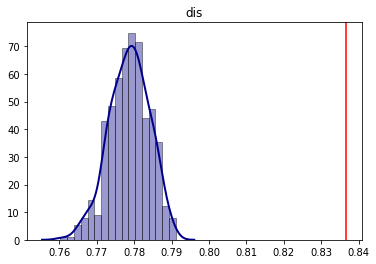

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(Infer_Segregation(delta_index, null_approach = "even_permutation").est_sim, 
                 hist=True, 
                 #kde=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    #plt.axvline(0, color = 'green')
plt.axvline([delta_index.statistic], color = 'red')
plt.title('dis')
plt.show()